# Imputing

Let's impute the missingness away!

In this Notebook we will have a look at various imputation methods and compare their results and performances.  
Compared imputation methods:
 + LOCF (last observed carried forward)
 + NOCB (next observation carried backward)
 + Mean imputation
 + Median imputation
 + BRITS (Single imputation)
 + SAITS (Single imputation)
 + mTAN (Multiple imputation)


In [34]:
%load_ext autoreload
%autoreload 2

from toy_dataset import data_utils
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Dataset

Here we create mcar missingness.


In [35]:
name = 'toydataset_small'
path = data_utils.datasets_dict[name]['path']
dataset = data_utils.ToyDataDf(path)

error_dict = dict()
# The missingness ratios to be evaluated
missingness = np.linspace(0.1,0.9,9)
# How many times should the imputation be repeated (and then take average)
repeat_imputation = 10

# Simple Imputations
 
Next we are looking at these basic imputation methods.

+ Mean
+ Median
+ LOCF
+ NOCB

As the data in a time series can be subject to different phenomena, the different basic imputation methods perform different depending on the phenomena. These phenomena can be:  

+ no trend or seasonality (fig1)
+ has trend, but no seasonality (fig2)
+ has seasonality, but no trend (fig3)
+ has both trend and seasonality (fig4)

<center>
    <img src="https://www.kaggleusercontent.com/kf/1924745/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..PhbwefajbtA-A0DXFrb2wg.UVB5orqrpslXWr9Bw-7gSalXdzYrqEYkRxTVIX43RGAp5Jp05W7oDH18dLxcTxcI92OlgkHnzYUJ6GQpdgRfvqJkBgy-UMl8g7OJ_U3ioeBIE9hD2OnhUfsHk4nByvHpfGG9tbE1EFgDgkssrvBXrpm_fiJ22sQ-yRi-DlCNJKfPE7pj8mVcESw2BA7CezJn1WXEItaCIdgqWbwRS4geOjOOl3BlY-vfV5r66dNbApL7ttC587gnIfdkG71AjMA0y-VHhfxrk4axcgmWJ5jFPfb0ZFx8W8lLByaMZxxxpZ26Y3j1jRLlk9AthhrcQhVoiHdqA-7JwFBeybkyAeA7LO6tMy0MHQ6iU0bhPgMkuB2IJY5DhanvAVeD8DZfaaUSWysx-jBVUE4RraBpVXJZirSJek6r3CyqRavIHQoIluUBGLPDNm1abW-k7w_1gR-5ZM072a8BlgFUzjsZvDK469VrCRQa-TQ9WhpaK1TbCnTeWSD02sSEAX5VMsFHZ0z1jtA1KKbSelt8hjKFGfWWevO85xccmtGltPz-cWGmxIaazoLyMQ4k2ZJqThSBlYPltGD5F0yl9rPGOpz77ErFnhIWZmIgoQJbNRkqzxIZvtTIZs0LjAUWJplF2hoP_KOZf07GysFwerkZsX_xz-19dt3MkWgVfpfWisaCfHUS-IYl0NrG54rKco__fjBac0_q.exxO0U1aYlTCABkuSntLzA/__results___files/figure-html/unnamed-chunk-1-1.png" alt="" style="width:500px;height:350px;"> 
    <br>
    Image from <a href="https://www.kaggle.com/code/juejuewang/handle-missing-values-in-time-series-for-beginners/report">Kaggle</a>.

</center>




### Mean Imputation

The dataset is a collection of many individual time series, which can potentially have different lengths. Missing values are filled with the mean of the *corresponding time series*.

In [36]:
name = 'mean'
impute_func = dataset.impute_mean
error_dict = dataset.get_mse_impute(name, error_dict, impute_func, missingness, repeat_imputation)

100%|██████████| 9/9 [00:03<00:00,  2.50it/s]


### Median Imputation

Same as for Mean Imputation, the mean is calculated for each time series.

In [37]:
name = 'median'
impute_func = dataset.impute_median
error_dict = dataset.get_mse_impute(name, error_dict, impute_func, missingness, repeat_imputation)

100%|██████████| 9/9 [00:04<00:00,  2.20it/s]


### LOCF Imputation

In [38]:
name = 'LOCF'
impute_func = dataset.impute_LOCF
error_dict = dataset.get_mse_impute(name, error_dict, impute_func, missingness, repeat_imputation)

100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


### NOCB Imputation

In [39]:
name = 'NOCB'
impute_func = dataset.impute_NOCB
error_dict = dataset.get_mse_impute(name, error_dict, impute_func, missingness, repeat_imputation)

100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


# More sophisticated Imputation methods

Let us look at more sophisticated imputation methods, such as Single Imputation methods, that try to approximate the conditional mean: 

$$\mathbb{E} [ ~ p(X_\text{miss} | X_\text{obs}, \theta) ~ ]  \qquad \leftarrow \text{Cond. mean} \quad$$ 

On the other hand we also look at a Multiple Imputation method, that does not try to approximate the conditional mean, but the entire probability density function:

$$X_\text{miss} \sim ~ p(X_\text{miss} | X_\text{obs}, \theta)$$


## Single Imputation

We look at the following Single Imputation methods:

+ SAITS
+ BRITS

### SAITS

In [40]:
name = 'SAITS'
impute_func = dataset.impute_SAITS
error_dict = dataset.get_mse_impute(name, error_dict, impute_func, missingness, repeat_imputation)

100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


### BRITS

In [41]:
name = 'BRITS'
impute_func = dataset.impute_BRITS
error_dict = dataset.get_mse_impute(name, error_dict, impute_func, missingness, repeat_imputation)

100%|██████████| 9/9 [00:23<00:00,  2.61s/it]


# Multiple Imputation - mTAN

We will look at the **mTAN** imputation.

# Visualize results


In [42]:
error_dict['mTAN'] =  [0.43174353,0.4409736, 0.4478371, 0.45952868,0.55937785,0.559954, 0.5702916,0.61676675,0.7723941] 

mean
median
LOCF
NOCB
SAITS
BRITS
mTAN


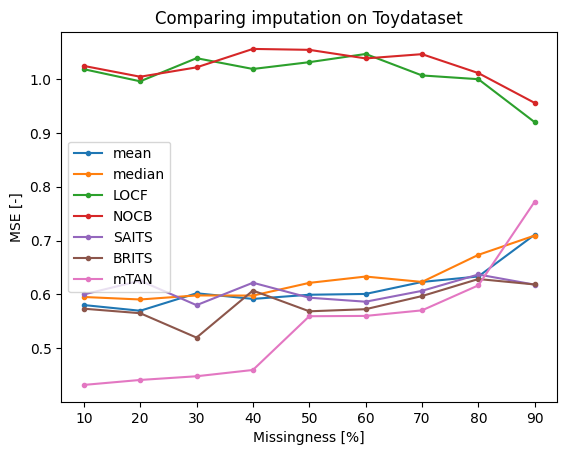

In [43]:
fig = plt.figure()
plt.title(f'Comparing imputation on {dataset.name}')
plt.ylabel('MSE [-]')
plt.xlabel('Missingness [%]')
for key in error_dict.keys():
    print(key)
    plt.plot(missingness*100, error_dict[key], marker='o', ms=3, label=key)
plt.legend(loc='best')
plt.show()


# Visualize some time series in order to see imputation

In [3]:
import matplotlib.pyplot as plt

In [5]:
imputed, X_intact, X, indicating_mask = dataset.impute_SAITS(missingness_rate=0.4)


No given device, using default device: cuda:0
Model initialized successfully. Number of the trainable parameters: 1324864
epoch 0: training loss 1.3342
epoch 1: training loss 2.1910
epoch 2: training loss 1.6702
epoch 3: training loss 1.4025
epoch 4: training loss 1.3077
epoch 5: training loss 1.2872
epoch 6: training loss 1.2977
epoch 7: training loss 1.2276
epoch 8: training loss 1.2378
epoch 9: training loss 1.1119
epoch 10: training loss 1.0648
epoch 11: training loss 1.1161
epoch 12: training loss 1.1009
epoch 13: training loss 1.0837
epoch 14: training loss 1.0285
epoch 15: training loss 1.0174
epoch 16: training loss 1.0248
epoch 17: training loss 1.0221
epoch 18: training loss 1.0030
epoch 19: training loss 0.9778
epoch 20: training loss 0.9582
epoch 21: training loss 0.9440
epoch 22: training loss 0.9508
epoch 23: training loss 0.9741
epoch 24: training loss 0.9339
epoch 25: training loss 0.9172
epoch 26: training loss 0.9543
epoch 27: training loss 0.9474
epoch 28: training l

id_92
mean
(50, 7)
median
(50, 7)
LOCF
(50, 7)


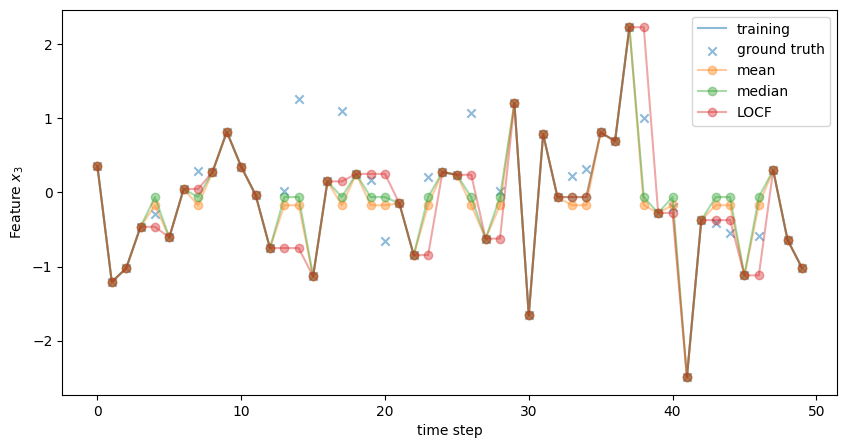

In [33]:
dataset.create_mcar_missingness(0.3)
X_intact, X, indicating_mask = dataset.get_missingness_data()
X = dataset.df_mis
# imputed, X_intact, X, indicating_mask
fig = plt.figure(figsize=(10,5))
sample_index = 2
feature_index = 3
id = dataset.df['id'].unique()[sample_index]
print(id)

y = X.loc[X['id']==id].iloc[:, feature_index]
time_labels = np.arange(len(y))
plt.plot(time_labels, y, alpha=0.5, label='training')
y = X_intact.loc[X_intact['id']==id].iloc[:, feature_index]
plt.scatter(time_labels, y, marker='x', alpha=0.5, label='ground truth')
# plt.plot(time_labels, imputed[sample_index, :, feature_index], marker='o', ms=4, alpha=0.5, label='SAITS')



imp_functions = [dataset.impute_mean, dataset.impute_median, dataset.impute_LOCF]
imp_names = ['mean', 'median', 'LOCF']
for imputation_func, name in zip(imp_functions, imp_names):
    print(name)
    print(imputed.shape)
    imputed = imputation_func(X)
    imputed = imputed.loc[imputed['id']==id]
    # imputed = imputed.iloc[:,2:]
    imputed = imputed.to_numpy()
    plt.plot(time_labels, imputed[:, feature_index], marker='o', alpha=0.4, label=name)
    

plt.ylabel(f'Feature $x_{feature_index}$')
plt.xlabel('time step')
plt.legend()
plt.show()

In [6]:
imputed = dataset.impute_mean(X)

In [ ]:
dataset.create_mcar_missingness(0.3)
dataset.get_missingness_data()

In [22]:
# print((X!=imputed).sum())
# print(imputed.isna().sum())
# print((indicating_mask==0).sum())
print('Nans df_mis: ', dataset.df_mis.isna().sum().sum())
print('Nans X: ', X.isna().sum().sum())

Nans df_mis:  750
Nans X:  750
